In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

# Read the dataframe
tama_df = pd.read_csv('engineered_tama_data.csv')
tama_df

,hebrew_city_name,city_code,year,total_open_requests,total_requests,total_approved_requests
0,אור יהודה,2400,2005,0,0.0,0.0
1,אור יהודה,2400,2006,0,0.0,0.0
2,אור יהודה,2400,2007,0,0.0,0.0
3,אור יהודה,2400,2008,0,1.0,0.0
4,אור יהודה,2400,2009,1,0.0,0.0
...,...,...,...,...,...,...
1075,תל אביב יפו,5000,2018,687,164.0,83.0
1076,תל אביב יפו,5000,2019,768,116.0,149.0
1077,תל אביב יפו,5000,2020,735,238.0,115.0
1078,תל אביב יפו,5000,2021,858,240.0,124.0


In [2]:
point_in_time = 2020

In [3]:
train_df = tama_df[tama_df['year'] <= point_in_time]
test_df = tama_df[tama_df['year'] > point_in_time]

In [4]:
# Save the model
import json
def save_sir_params(city, beta, gamma):
    model = {
        'city': int(city),
        'beta': float(beta),
        'gamma': float(gamma),
    }
    sir_models = [model]
    with open("sir_model.json", "r") as sir_model_file:
        sir_models = json.load(sir_model_file)
        sir_models.append(model)
    with open("sir_model.json", 'w') as sir_model_file:
        json.dump(sir_models, sir_model_file,
                  indent=4,
                  separators=(',', ': '))

In [5]:
def SIR(X, t, beta, gamma, N):
    """
    SIR model for tama requests prediction.
    S = X[0], I=X[1], R=X[2]
    """
    dSdt = -beta * X[0] * X[1] / N
    dIdt = beta * X[0] * X[1] / N - gamma * X[1]
    dRdt = gamma * X[1]
    return [dSdt, dIdt, dRdt]
    
def infectedSIR(time_seq, beta, gamma):
    N = 10000
    I0 = 1
    X0 = [N-I0, I0, 0]
    return odeint(SIR, X0, time_seq, args=(beta, gamma, N))[:,1]
    
def min_diff(params, total_requests_data, time_data):
            beta, gamma = params
            guess = infectedSIR(time_data, beta, gamma)
            return np.sum(np.square(guess - total_requests_data))
            
            
def build_sir_models(train_df):
    cities = list(set(train_df['city_code']))
    for city in cities:
        current_city = train_df[train_df['city_code'] == city].sort_values(by='year', ignore_index=True)
        current_city['year'] = current_city['year'] - 2005
        bounds=((0.001, None), (0.001, 10))
        result = minimize(min_diff, [0.5, 0.1], 
        args=(current_city['total_requests'].values, current_city['year'].values), 
        method='Nelder-Mead', bounds=bounds, tol=1e-6)
        beta_opt, gamma_opt = result.x
        save_sir_params(city, beta_opt, gamma_opt)

In [6]:
build_sir_models(train_df)

In [7]:
import json
def predict_total_requests(city, year):
    with open("sir_model.json") as sir_nodel_file:
        sir_models = json.load(sir_nodel_file)
        city_model = [model for model in sir_models if model['city'] == city][0]
    normalized_year = year - 2005
    guess = infectedSIR(np.linspace(0, normalized_year, normalized_year + 1), city_model['beta'], city_model['gamma'])
    return guess[normalized_year]

In [8]:
predict_total_requests(city=8700, year=2012)

27.649363838313782

In [9]:
tama_df['predicted_total_requests'] = tama_df.apply(lambda row: predict_total_requests(row['city_code'], row['year']), axis=1)

<Axes: xlabel='year'>

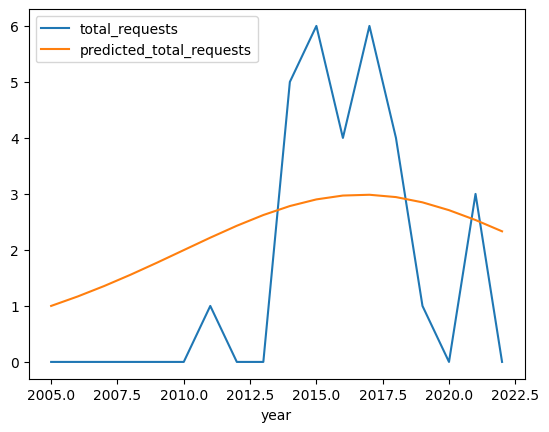

In [10]:
example_city_plot = tama_df[tama_df['city_code'] == 7200]
example_city_plot.set_index('year')[['total_requests', 'predicted_total_requests']].plot()

<Axes: xlabel='year'>

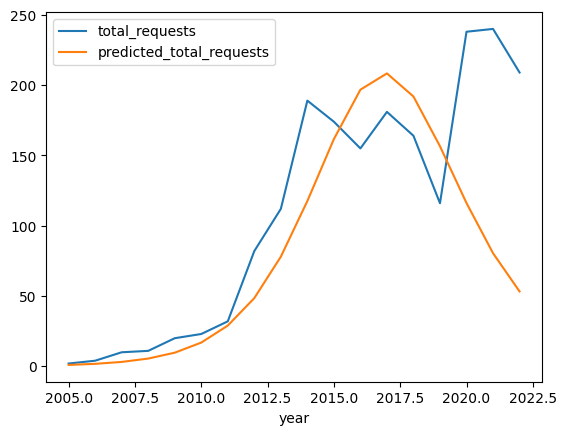

In [11]:
example_city_plot = tama_df[tama_df['hebrew_city_name'] == 'תל אביב יפו']
example_city_plot.set_index('year')[['total_requests', 'predicted_total_requests']].plot()

In [12]:
np.sqrt(mean_squared_error(tama_df['predicted_total_requests'], tama_df['total_requests']))

10.598915771852846

<Axes: xlabel='year'>

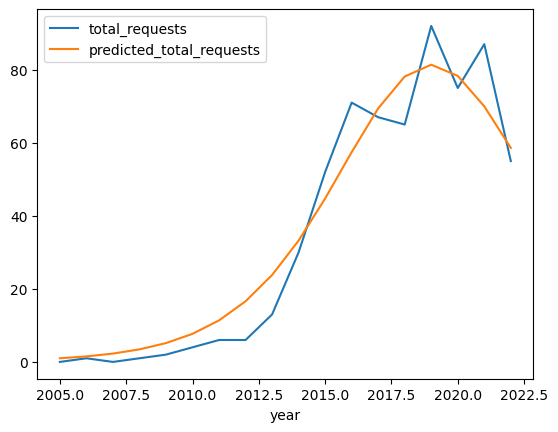

In [13]:
example_city_plot = tama_df[tama_df['hebrew_city_name'] == 'ירושלים']
example_city_plot.set_index('year')[['total_requests', 'predicted_total_requests']].plot()

<Axes: xlabel='year'>

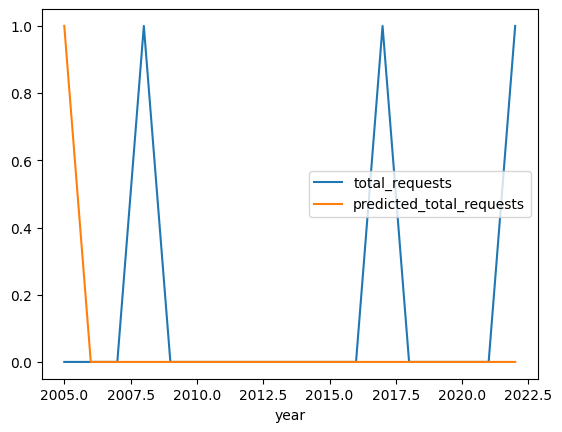

In [14]:
example_city_plot = tama_df[tama_df['hebrew_city_name'] == 'אור יהודה']
example_city_plot.set_index('year')[['total_requests', 'predicted_total_requests']].plot()

In [15]:
from matplotlib import pyplot as plt
def plot_sir(city):
    with open("sir_model.json") as sir_nodel_file:
        sir_models = json.load(sir_nodel_file)
        city_model = [model for model in sir_models if model['city'] == city][0]
    N = 10000
    I0 = 1
    X0 = [N-I0, I0, 0]
    t_data = np.linspace(0, 30, 30)
    S = odeint(SIR, X0, t_data, args=(city_model['beta'], city_model['gamma'], N))[:,0]
    I = odeint(SIR, X0, t_data, args=(city_model['beta'], city_model['gamma'], N))[:,1]
    R = odeint(SIR, X0, t_data, args=(city_model['beta'], city_model['gamma'], N))[:,2]
    N = S + I + R
    plt.plot(t_data, S, label = "Sensitive - Eligible to apply a Tama request", color='gray')
    plt.plot(t_data, I, label = "Infected - New Requests", color='red')
    plt.plot(t_data, R, label = "Recoverd - Approved Requests", color='green')
    plt.plot(t_data, N, label = "Population, N = S + I + R", color='black')
    plt.legend()

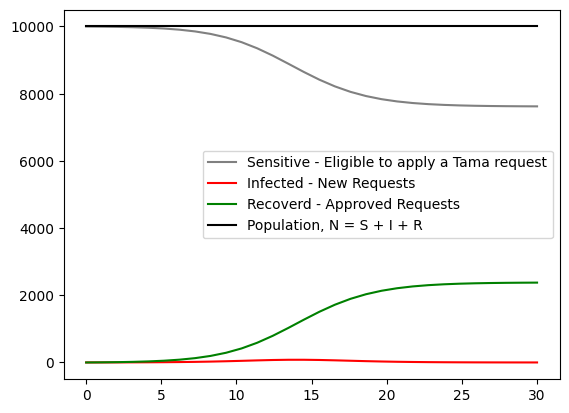

In [16]:
plot_sir(3000)

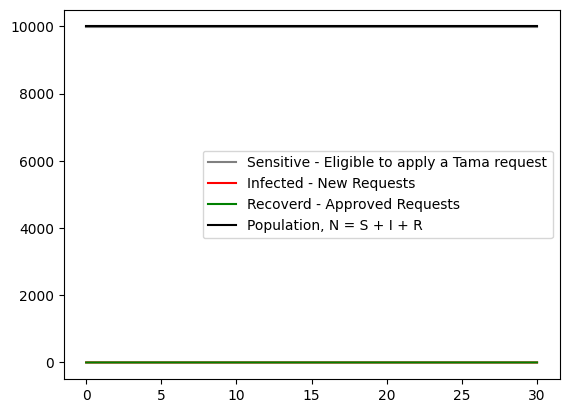

In [17]:
plot_sir(2400)

In [18]:
tama_df[tama_df['hebrew_city_name'] == 'אור יהודה']

,hebrew_city_name,city_code,year,total_open_requests,total_requests,total_approved_requests,predicted_total_requests
0,אור יהודה,2400,2005,0,0.0,0.0,1.000000e+00
1,אור יהודה,2400,2006,0,0.0,0.0,4.544571e-05
2,אור יהודה,2400,2007,0,0.0,0.0,2.174134e-09
3,אור יהודה,2400,2008,0,1.0,0.0,-8.580458e-11
4,אור יהודה,2400,2009,1,0.0,0.0,-3.774208e-11
5,אור יהודה,2400,2010,1,0.0,1.0,-2.069759e-11
6,אור יהודה,2400,2011,0,0.0,0.0,-3.653103e-12
7,אור יהודה,2400,2012,0,0.0,0.0,-1.226052e-12
8,אור יהודה,2400,2013,0,0.0,0.0,-6.857186e-13
9,אור יהודה,2400,2014,0,0.0,0.0,-1.453851e-13


In [19]:
tama_df[tama_df['hebrew_city_name'] == 'ירושלים']

,hebrew_city_name,city_code,year,total_open_requests,total_requests,total_approved_requests,predicted_total_requests
522,ירושלים,3000,2005,0,0.0,0.0,1.000000
523,ירושלים,3000,2006,0,1.0,0.0,1.512364
524,ירושלים,3000,2007,1,0.0,0.0,2.283339
525,ירושלים,3000,2008,1,1.0,0.0,3.438466
526,ירושלים,3000,2009,2,2.0,0.0,5.157927
527,ירושלים,3000,2010,4,4.0,0.0,7.692447
528,ירושלים,3000,2011,8,6.0,1.0,11.373782
529,ירושלים,3000,2012,13,6.0,7.0,16.604502
530,ירושלים,3000,2013,12,13.0,3.0,23.797921
531,ירושלים,3000,2014,22,30.0,6.0,33.225849


In [20]:
tama_df[tama_df['city_code'] == 2620]

,hebrew_city_name,city_code,year,total_open_requests,total_requests,total_approved_requests,predicted_total_requests
792,קרית אונו,2620,2005,0,0.0,0.0,1.000000
793,קרית אונו,2620,2006,0,0.0,0.0,1.372137
794,קרית אונו,2620,2007,0,1.0,0.0,1.860653
795,קרית אונו,2620,2008,1,0.0,1.0,2.483105
796,קרית אונו,2620,2009,0,1.0,0.0,3.244116
797,קרית אונו,2620,2010,1,0.0,0.0,4.122806
798,קרית אונו,2620,2011,1,4.0,0.0,5.059562
799,קרית אונו,2620,2012,5,5.0,2.0,5.950088
800,קרית אונו,2620,2013,8,9.0,4.0,6.657579
801,קרית אונו,2620,2014,13,9.0,0.0,7.048482


<Axes: xlabel='year'>

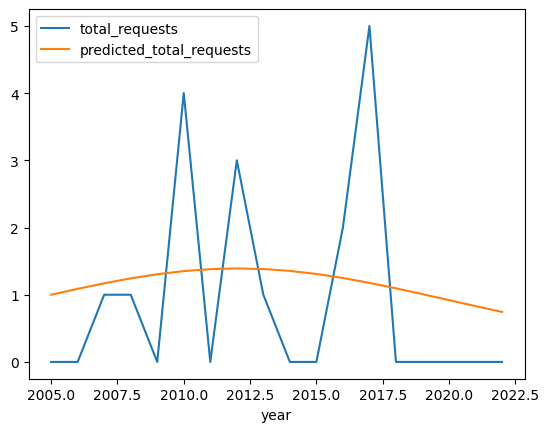

In [21]:
example_city_plot = tama_df[tama_df['city_code'] == 2800]
example_city_plot.set_index('year')[['total_requests', 'predicted_total_requests']].plot()